In [25]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
from pct.data.prices import PriceHistory

### Downloading historical data

In [57]:
tickers = ['AAPL','MSFT','AMZN','GOOG','FB','WMT','JPM','TSLA','NFLX','ADBE']
data_path = '/Users/yevgeniy/Development/projects/finance/portfolio-construction-tool/data/prices.csv'
data_path_10yrs = '/Users/yevgeniy/Development/projects/finance/portfolio-construction-tool/data/prices_10yrs.csv'
data_path_5yrs = '/Users/yevgeniy/Development/projects/finance/portfolio-construction-tool/data/prices_5yrs.csv'

In [60]:
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta

today = datetime.today().date()

from_date_10yrs = today - relativedelta(years=10)
from_date_5yrs = today - relativedelta(years=5)
print(f"From Date 10years: {from_date_10yrs}")
print(f"From Date 5years: {from_date_5yrs}")


From Date 10years: 2011-04-10
From Date 5years: 2016-04-10


In [61]:

price_history = PriceHistory(tickers = tickers)
price_history.download_prices()
price_history.save_prices(save_fpath = data_path)


price_history_10yrs = PriceHistory(tickers = tickers)
price_history_10yrs.download_prices(from_date=from_date_10yrs)
price_history_10yrs.save_prices(save_fpath = data_path_10yrs)

price_history_5yrs = PriceHistory(tickers = tickers)
price_history_5yrs.download_prices(from_date=from_date_5yrs)
price_history_5yrs.save_prices(save_fpath = data_path_5yrs)

print(f"6 months: {len(price_history.prices)}")
print(f"10 years: {len(price_history_10yrs.prices)}")
print(f"5 years: {len(price_history_5yrs.prices)}")

6 months: 1250
10 years: 24881
5 years: 12590


In [68]:
df_prices = price_history_5yrs.prices

In [69]:
df_prices.head(1)

,date,open,high,low,close,volume,dividends,stock_splits,ticker
0,2016-04-11,25.33849,25.719834,25.305936,25.350115,117630000,0.0,0.0,AAPL


### Loading Historical data

In [70]:
from pct.data.data_reader import SimpleIndexedCSVDataset

In [230]:
ds = SimpleIndexedCSVDataset(fpath=data_path_5yrs)
df_prices = ds.read()
df_prices[df_prices.ticker == 'FB'].head(1)

,ticker,open,high,low,close,volume
date,,,,,,
2016-04-11,FB,110.699997,110.910004,108.769997,108.989998,39762300


### 5 years only

### Pivoting dataframe

In [232]:
from tabulate import tabulate

In [233]:
df_prices.reset_index(inplace=True)
df_prices = df_prices.pivot(index='date', columns='ticker', values='close')

In [234]:
print(tabulate(df_prices.head(5), headers="keys"))

date                    AAPL    ADBE    AMZN      FB    GOOG      JPM     MSFT    NFLX    TSLA      WMT
-------------------  -------  ------  ------  ------  ------  -------  -------  ------  ------  -------
2016-04-11 00:00:00  25.3501   92.95  595.93  108.99  736.1   50.6131  49.8007  102.68  49.984  60.3188
2016-04-12 00:00:00  25.6803   93.42  603.17  110.61  743.09  51.5523  50.1125  106.98  49.564  61.5717
2016-04-13 00:00:00  26.0523   94.53  614.82  110.51  751.72  53.7351  50.7544  109.65  50.906  61.8849
2016-04-14 00:00:00  26.0663   94.44  620.75  110.84  753.2   54.4308  50.7636  110.42  50.372  61.5717
2016-04-15 00:00:00  25.5431   95.16  625.89  109.64  759     53.8047  51.0295  111.51  50.902  61.8044


In [140]:
#df_prices[df_prices.index > '2020-01-01'].plot(figsize=(30, 20))

#### Normalizing result to start with the same prices

dataframe devided by the first row


In [235]:
df_normalized_prices = (df_prices / df_prices.iloc[0])

<AxesSubplot:xlabel='date'>

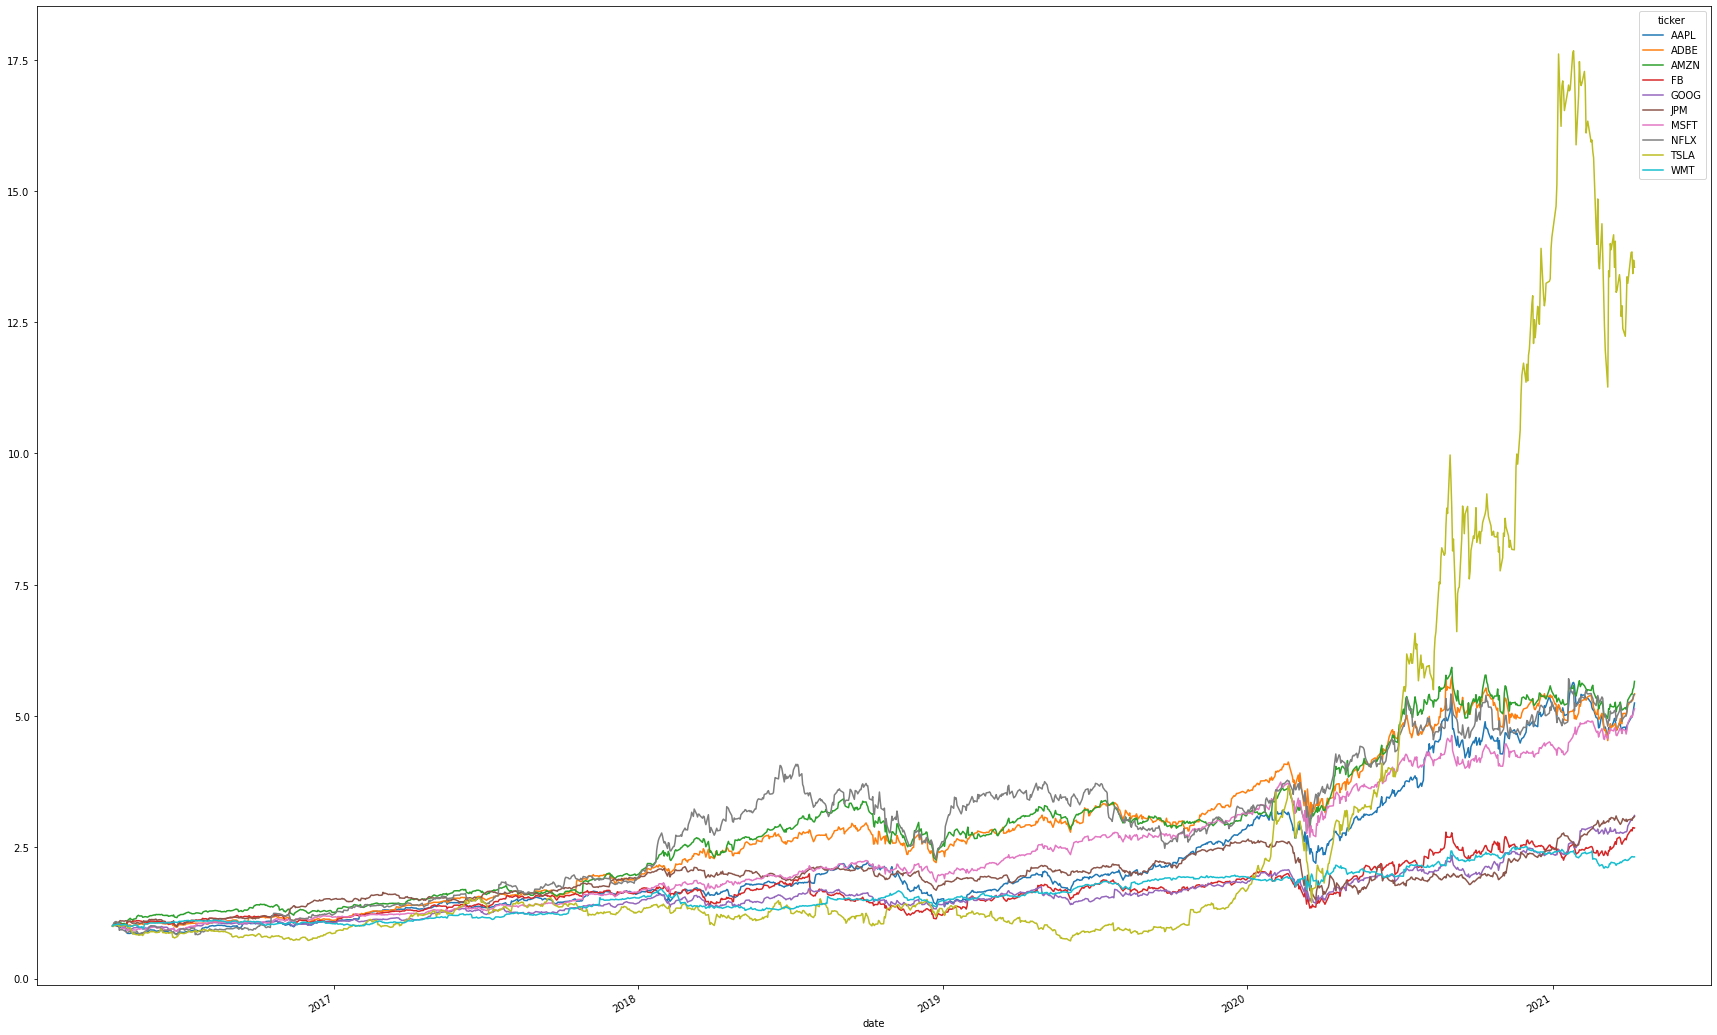

In [236]:
df_normalized_prices.plot(figsize=(30, 20))

In [95]:
# Calculate log return 
df_return = np.log(1 + df_prices.pct_change())

In [101]:
print(tabulate(df_return[1:5], headers="keys"))

date                         AAPL          ADBE        AMZN            FB        GOOG         JPM         MSFT        NFLX         TSLA          WMT
-------------------  ------------  ------------  ----------  ------------  ----------  ----------  -----------  ----------  -----------  -----------
2016-04-12 00:00:00   0.0129411     0.00504375   0.0120759    0.0147544    0.00945126   0.0183868  0.00624109   0.0410246   -0.00843823   0.0205591
2016-04-13 00:00:00   0.0143834     0.0118118    0.0191305   -0.000904473  0.0115467    0.0414696  0.0127271    0.0246516    0.026716     0.00507389
2016-04-14 00:00:00   0.000535404  -0.000952493  0.00959887   0.00298165   0.00196694   0.0128639  0.000180743  0.00699777  -0.0105453   -0.00507389
2016-04-15 00:00:00  -0.0202755     0.00759499   0.00824624  -0.0108854    0.00767096  -0.0115702  0.00522478   0.00982303   0.0104667    0.0037716


<AxesSubplot:xlabel='date'>

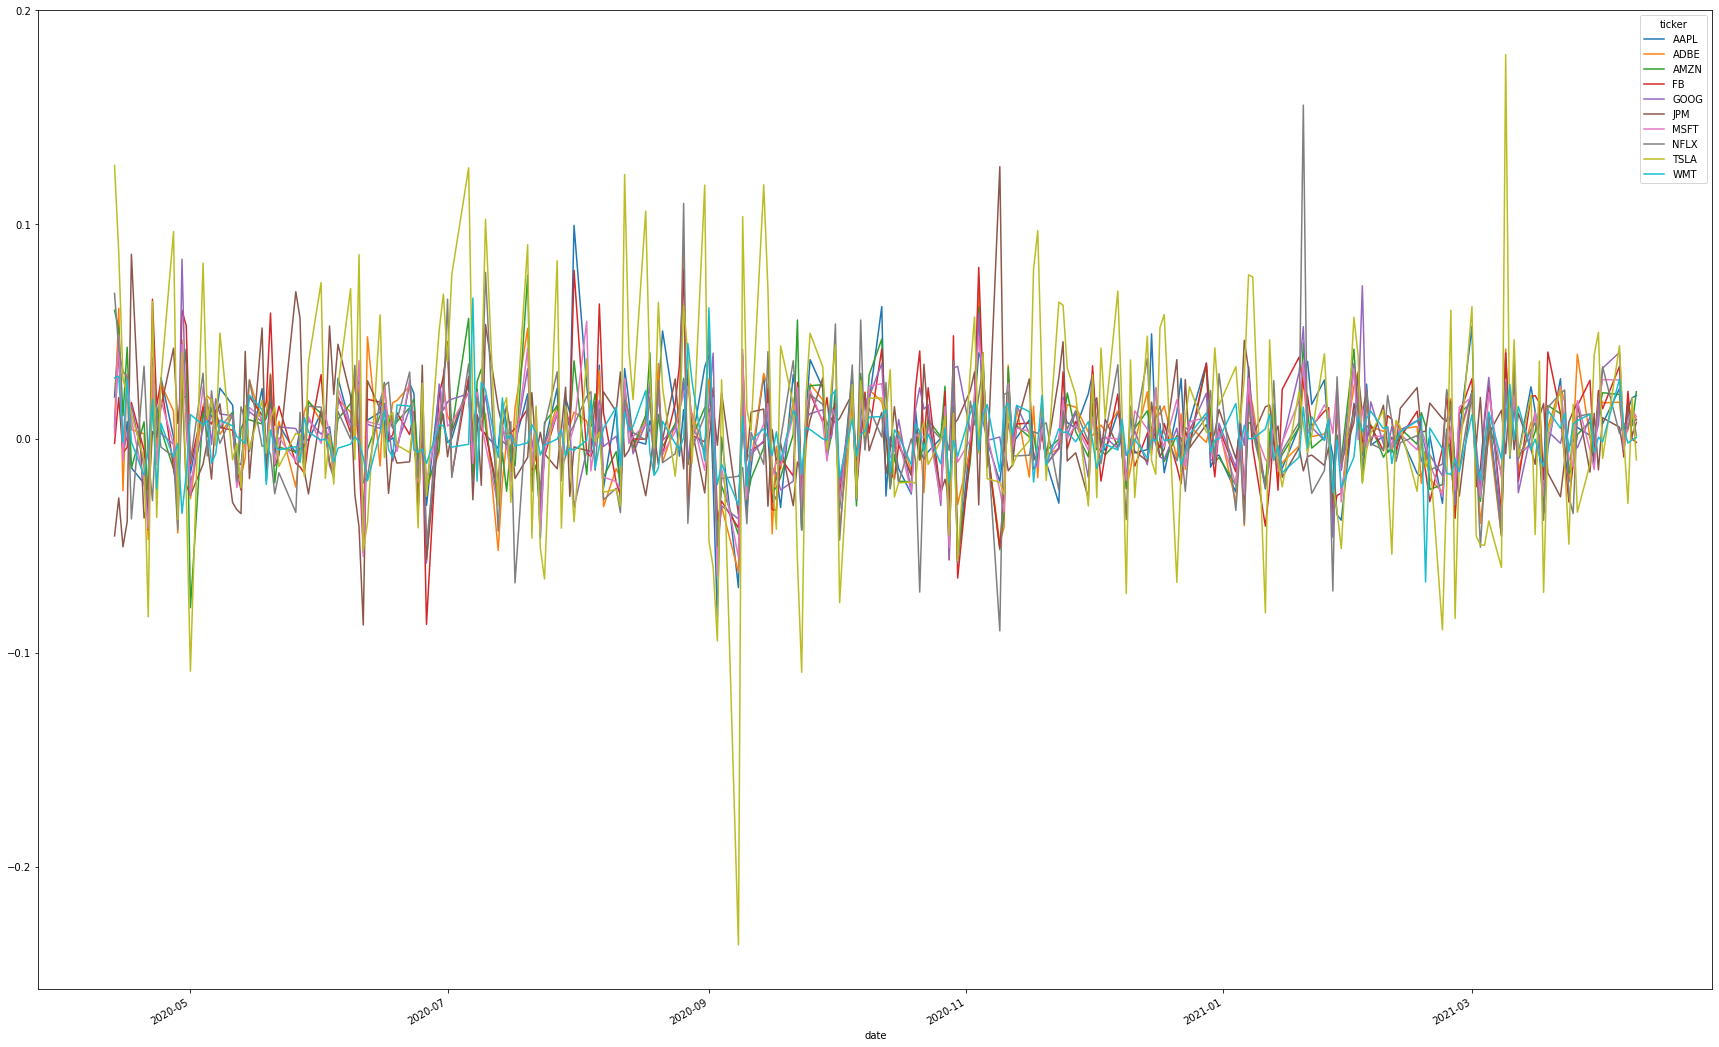

In [163]:
df_return[df_return.index > '2020-04-10'].plot(figsize=(30, 20))
# df_return.plot(figsize=(30, 20))

Return correlation between assets using 5 years of returns. The lower the better to find opportunities for diversification.

In [180]:
df_corr = df_return.corr()
df_corr.style.background_gradient(cmap='coolwarm').set_precision(4).set_properties(**{'font-size': '12pt'})

ticker,AAPL,ADBE,AMZN,FB,GOOG,JPM,MSFT,NFLX,TSLA,WMT
ticker,,,,,,,,,,
AAPL,1.0000,0.6460,0.6176,0.5961,0.6549,0.4418,0.7154,0.4645,0.4136,0.3518
ADBE,0.6460,1.0000,0.6770,0.6162,0.7020,0.3898,0.8062,0.5679,0.4197,0.3440
AMZN,0.6176,0.6770,1.0000,0.6213,0.6702,0.2697,0.7076,0.5975,0.3797,0.2916
FB,0.5961,0.6162,0.6213,1.0000,0.6838,0.3548,0.6362,0.4691,0.3350,0.2411
GOOG,0.6549,0.7020,0.6702,0.6838,1.0000,0.4830,0.7812,0.5186,0.3711,0.3168
JPM,0.4418,0.3898,0.2697,0.3548,0.4830,1.0000,0.5020,0.2133,0.2544,0.2588
MSFT,0.7154,0.8062,0.7076,0.6362,0.7812,0.5020,1.0000,0.5390,0.4226,0.4007
NFLX,0.4645,0.5679,0.5975,0.4691,0.5186,0.2133,0.5390,1.0000,0.3352,0.2556
TSLA,0.4136,0.4197,0.3797,0.3350,0.3711,0.2544,0.4226,0.3352,1.0000,0.1630


Return correlation between assets using 5 years of returns. The lower the better to find opportunities for diversification.

We try to optimize by minimizing, i.e: minimizing risk for a specified return for specified level of return. 


We can minimize multiple things. We can minimize volatility; we can minimize negative Sharp; minimize return.

A simple contraint would be that we can't have more than 100% allocation, bounds. We want to invest all, this is another constraint. 



In [164]:
from scipy.optimize import optimize, Bounds, LinearConstraint

optimize(func, weights, expected_return, covariance)

func is the function that we want to minimize

weights that wea ere solving for and corresponds to the weights of the assets in out portfolio. We need to start off with guess, equally weighted initially

expected_return and covariance is for optimizer not to vary

So what the optimizer does is it searches for the vector of portfolio weights (W) that minimize func given our supplied expected returns and covariance matrix.


#### Bounds

In [117]:
# Bounds for each ticker, weight for instruments should not exceed 100%.
# We don't do any shorts
bounds = tuple((0, 1) for symbol in range(number_of_tickers))

# Bounds with scipy
opt_bounds = Bounds(0,1)


#### Constraints

In [309]:
# Constraints

# Define the constraints, the sum of each weight must not exceed 100%.

# weights to sum to 1 in order for it to be a proper porfolio without any cash left
# I am using equality constraints, so the function should return something like 0
# 
sum_of_weights = lambda weights: np.sum(weights) - 1.0
# print(sum_of_weights([0.1,0.3,0.3]))

# pre-specified target returns to optimise but to have return that is not too low

expected_returns = np.array([[ 0.080],
                             [ 0.092],
                             [ 0.092],
                             [ 0.017],
                             [ 0.034],
                             [ 0.001],
                             [ 0.010],
                             [ 0.079],
                             [ 0.079],
                             [ 0.8]])
# print(expected_returns.T)
target_return = lambda weights: target_return - weights.T@expected_returns


constraints = ({'type': 'eq', 'fun': sum_of_weights}, {'type': 'eq', 'fun': expected_returns})

#### Initial values

In [240]:
# Equally distributed
equally_weighted = lambda tickers: len(tickers) * [1 / len(tickers)]
print(equally_weighted(tickers))

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


### Minimization

In [237]:
def portfolio_returns(weights, df_portfolio):
    """
    Simple optimisation only looking into returns
    """

    # Distribute allocation by weights
    df_portfolio = df_portfolio * weights
    value = df_portfolio.sum(axis = 1)
    value = value[-1]

    # Minimum is a maximum, we need to negate, we need to negate
    return -1


In [266]:
data = df_normalized_prices[['TSLA', 'WMT']]

In [268]:
data.head()

ticker,TSLA,WMT
date,,
2016-04-11,1.000000,1.000000
2016-04-12,0.991597,1.020772
2016-04-13,1.018446,1.025964
2016-04-14,1.007762,1.020772
2016-04-15,1.018366,1.024629


In [290]:
test_data = data * alloc
values = test_data.sum(axis=1)
daily_returns = values.pct_change().to_numpy()
print(daily_returns[1:])


[ 0.00618457  0.01592204 -0.00776546 ... -0.02587374  0.01621144
 -0.00840695]


In [264]:

bounds =  tuple((0, 1) for symbol in range(number_of_tickers))

print(f"Bounds: {bounds}")

sum_of_weights = lambda weights: np.sum(weights) - 1.0
# print(sum_of_weights([0.1,0.3,0.3]))

# pre-specified target returns to optimise but to have return that is not too low

expected_returns = np.array([[ 0.080],
                             [ 0.092],
                             [ 0.092],
                             [ 0.017],
                             [ 0.034],
                             [ 0.001],
                             [ 0.010],
                             [ 0.079],
                             [ 0.079],
                             [ 0.8]])
# print(expected_returns.T)
target_return = lambda weights: target_return - weights.T@expected_returns


def portfolio_returns(alloc, data):

    # Distribute allocation by weights
    data = data * alloc
    value = data.sum(axis = 1)
    value = value[-1]

    # Minimum is a maximum, we need to negate, we need to negate
    return -value

def constraints(alloc):
    return np.sum(alloc) -1


Bounds: ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1))


In [296]:
allocation = sci_opt.minimize(
    fun=portfolio_returns,
    x0 = equally_weighted(tickers),
    args=df_normalized_prices,
    method='SLSQP',
    bounds=bounds,
    constraints=(
        {'type': 'eq', 'fun': sum_of_weights }
        )
    )

optimized_weights = { t:round(a[1]) for t,a in zip(tickers, np.ndenumerate(allocation['x']))}


print(f"status: {allocation.status}")
print(f"success: {allocation.success}")
print(f"message: {allocation.message}")
print(f"optimized weights: {optimized_weights}")

print("-------------------------------------")
# print(allocation)


status: 0
success: True
message: Optimization terminated successfully
optimized weights: {'AAPL': 0, 'MSFT': 0, 'AMZN': 0, 'GOOG': 0, 'FB': 0, 'WMT': 0, 'JPM': 0, 'TSLA': 0, 'NFLX': 1, 'ADBE': 0}
-------------------------------------


In [314]:

# W = np.ones((factor_moments.shape[0],1))*(1.0/factor_moments.shape[0])
W = equally_weighted(tickers)

expected_returns = np.array([[ 0.10],
                             [ 0.092],
                             [ 0.092],
                             [ 0.017],
                             [ 0.034],
                             [ 0.001],
                             [ 0.010],
                             [ 0.079],
                             [ 0.079],
                             [ 0.8]])

# Function that runs optimizer
def optimize(func, W, exp_ret, cov, target_return):
    opt_bounds = Bounds(0, 1)
    opt_constraints = (
                        {'type': 'eq', 'fun': lambda W: np.sum(W) - 1}
                        # {'type': 'eq','fun': lambda W: target_return - W.T@exp_ret}
                       )

    optimal_weights = sci_opt.minimize(func, 
                               W, 
                               args=(exp_ret, cov),
                               method='SLSQP',
                               bounds=opt_bounds,
                               constraints=opt_constraints)

    optimized_weights = { t:round(a[1]) for t,a in zip(tickers, np.ndenumerate(optimal_weights['x'])) }

    return optimized_weights

def ret_risk(W, exp_ret, cov):
    return -((W.T@exp_ret) / (W.T@cov@W)**0.5)


In [315]:
x = optimize(ret_risk, W, expected_returns, df_corr, target_return=0.055)

x

{'AAPL': 0,
 'MSFT': 0,
 'AMZN': 0,
 'GOOG': 0,
 'FB': 0,
 'WMT': 0,
 'JPM': 0,
 'TSLA': 0,
 'NFLX': 0,
 'ADBE': 1}

#### Function to optimize

Since we are using an optimizer function that minimizes things, we need to add a negative sign on our return to risk ratio — that way when we minimize it, we are actually maximizing it.


Mathematically, we define the Sharpe Ratio as the following:

\begin{equation*}
\text{Sharpe Ratio} = \frac{(R_p - R_f)}{\sigma_p}
\end{equation*}

Where:

$
\begin{align}
\ R_p & = \text{Return of Portfolio} \\
\ R_f & = \text{Risk-Free Rate} \\
\ \sigma_p & = \text{Standard Deviation of Portfolio's Excess Return} \\
\end{align}
$


To calculate the expected returns, we use the following formula:

\begin{equation*}
\ R_p = (w_{1}r_{1}) + (w_{2}r_{2}) + \cdots + (w_{n}r_{n})
\end{equation*}

Where:

$
\begin{align}
\ r_{i} & = \text{Return of Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\end{align}
$

To calculate the standard deviation of the protfolio, we use the following formula:

\begin{equation*}
\ \sigma_p = \sqrt{(w_{i}^2 \sigma_i^2) + (w_{j}^2 \sigma_j^2) + (2w_{j}w_{i} p_{i,j} \sigma_i \sigma_j)}
\end{equation*}

Where:

$
\begin{align}
\ \sigma_{i} & = \text{Standard Deviation of Returns for Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\ p_{i,j} & = \text{Correlation Coefficent between the returns of asset i and asset j} \\
\end{align}
$



#### Optimization

1. Optimize risk by optimizing Sharp Ration
2. Optimize weights
3. Optimize volatility ratio



In [ ]:

def calculate_negative_sharpe_ratio(df_portfolio_returns: pd.DataFrame, weights: list) -> np.array:

    weights = np.array(weights)

    # Calculate the returns annualizing them (252).
    returns = np.sum(df_portfolio_returns.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).

    print(weights.T)

    vol = np.sqrt(
        np.dot(weights.T, np.dot(df_portfolio_returns.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return ()






## References

[Portfolio Optimization With SciPy](https://towardsdatascience.com/portfolio-optimization-with-scipy-aa9c02e6b937)


https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

[Understanding Portfolio Optimization](https://towardsdatascience.com/understanding-portfolio-optimization-795668cef596)

[Understanding Correlation And Diversification](https://towardsdatascience.com/understanding-correlation-and-diversification-661c19a26555)
